In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-a8aed9fadacf>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data   = data[:,1:]
dataNorm = data / np.max(data)

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [3]:
# create a class for the model
def createTheMNISTNet(optimizerAlgo, learningRate):

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr(torch.optim, optimizerAlgo)
  optimizer = optifun(net.parameters(),lr=learningRate)

  return net,lossfun,optimizer

In [4]:
# a function that trains the model

def funtion2trainTheModel(optimizerType,learningrate):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(optimizerType,learningrate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [ ]:
# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))


# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = funtion2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])
    print(f"Optimizer type {opto}. Learning rate {idx_l+1}/{len(learningRates)}")

Optimizer type SGD. Learning rate 1/6
Optimizer type SGD. Learning rate 2/6
Optimizer type SGD. Learning rate 3/6
Optimizer type SGD. Learning rate 4/6
Optimizer type SGD. Learning rate 5/6
Optimizer type SGD. Learning rate 6/6
Optimizer type RMSprop. Learning rate 1/6
Optimizer type RMSprop. Learning rate 2/6
Optimizer type RMSprop. Learning rate 3/6
Optimizer type RMSprop. Learning rate 4/6
Optimizer type RMSprop. Learning rate 5/6
Optimizer type RMSprop. Learning rate 6/6
Optimizer type Adam. Learning rate 1/6
Optimizer type Adam. Learning rate 2/6
Optimizer type Adam. Learning rate 3/6
Optimizer type Adam. Learning rate 4/6
Optimizer type Adam. Learning rate 5/6
Optimizer type Adam. Learning rate 6/6


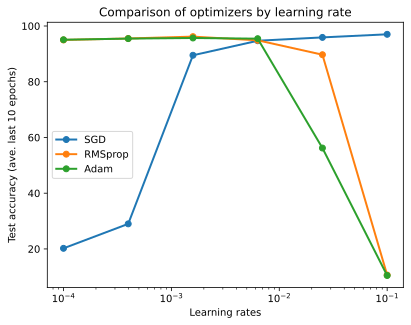

In [ ]:
# plot the results!
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

##Take aways
- RMS and Adam do comparably well
- SGD do well for large learning rates and poorly for small learning rates
- Remember that rms and adam automatically scale the learning rate so they do beter when initializing a small learning rate
- small learning rates with SGD tend to cause vanishing gradient